### Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_forecasting-USU/blob/main/Lectures%20and%20codes/Module%207-%20Deep%20Sequence%20Modeling/Module7_Univariate_RNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 7: Deep Sequence Modeling (timeseries forecasting)

This module provides a comprehensive overview of fundamental concepts and techniques related to deep sequence modeling. Part one explores deep learning for timeseries data, highlighting the inadequacy of DNN and CNN architectures for this task and introducing the recurrent neural network (RNN) as a solution.

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow first: https://www.tensorflow.org/install


In [1]:
import tensorflow
tensorflow.__version__

'2.17.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv", index_col="Month")
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [4]:
# if you are working with Pandas, your first job should be changing the type of the index to datetime and then to period! This is a compatibility issue with other packages.
df.index

Index(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
       '1949-07', '1949-08', '1949-09', '1949-10',
       ...
       '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
       '1960-09', '1960-10', '1960-11', '1960-12'],
      dtype='object', name='Month', length=144)

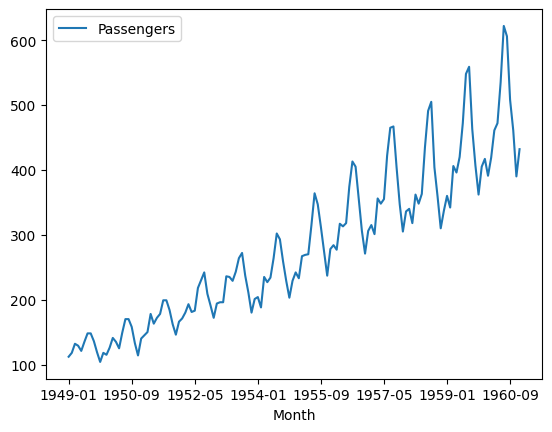

In [5]:
df.plot()
plt.show()

## Splitting the data:

**Computing the number of samples we'll use for each data split**

In [6]:
len(df)

144

In [7]:
num_train_samples = int(0.6 * len(df))
num_val_samples = int(0.20 * len(df))
num_test_samples = len(df) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 86
num_val_samples: 28
num_test_samples: 30


# Preparing the data

## Stationarity



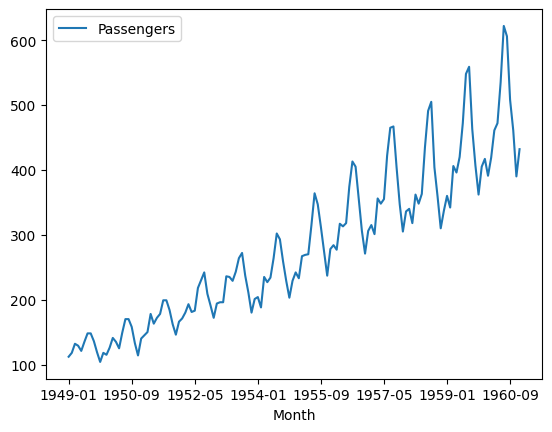

In [8]:
df.plot()
plt.show()

In [9]:
# the data is clearly not stationary. We will go ahead and use the log transformation and then first differencing
df['LogPassengers'] = np.log(df['Passengers'])
df['DiffLogPassengers']= df['LogPassengers'].diff(1)

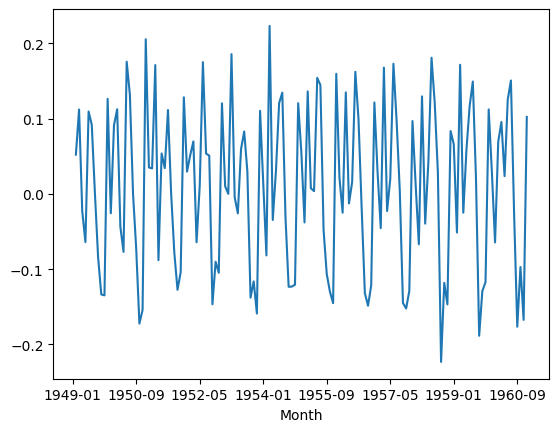

In [10]:
df['DiffLogPassengers'].plot()
plt.show()

In [11]:
df.dropna(inplace=True)

In [12]:
df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-02,118,4.770685,0.052186
1949-03,132,4.882802,0.112117
1949-04,129,4.859812,-0.022990
1949-05,121,4.795791,-0.064022
1949-06,135,4.905275,0.109484




## Normalizing the data

In [13]:
# in this example, because we work with stationary DiffLogPassengers, we don't need to normalize the data. If you want, you cant try running the following:

# mean = df[:num_train_samples].mean(axis=0)
# df -= mean
#std = df[:num_train_samples].std(axis=0)
# df /= std

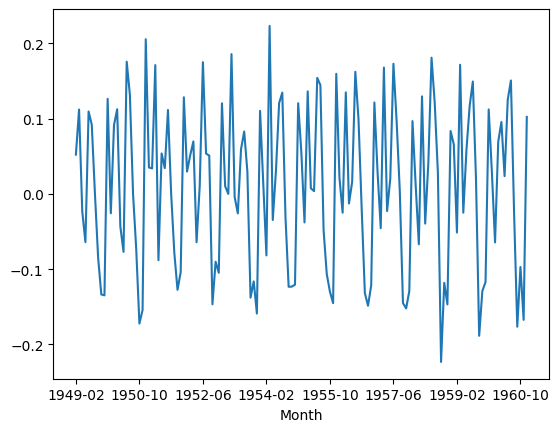

In [14]:
df['DiffLogPassengers'].plot()
plt.show()

## Time series batch generator
**Instantiating datasets for training, validation, and testing**
https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [33]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(1,10) # [1, 2, 3, 4, 5, 6, 7, 8, 9]
batch_size = 1 # Number of timeseries samples in each batch (except maybe the last one). If None, the data will not be batched (the dataset will yield individual samples).
sequence_length = 3 # Length of the output sequences (in number of timesteps).
h = 1 # number of h steps ahead for forecasting
delay = sequence_length + h -1  # number of delayed timesteps to start predictions

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-delay],
    targets=int_sequence[delay:],
    sequence_length=sequence_length,
    sequence_stride= 1, # Number of timesteps between two consecutive output sequences.
    batch_size=batch_size,
    shuffle = False, # Whether to shuffle output samples, or instead draw them in chronological order.
)

for inputs, targets in dummy_dataset:
  print(inputs, targets)

tf.Tensor([[1 2 3]], shape=(1, 3), dtype=int32) tf.Tensor([4], shape=(1,), dtype=int32)
tf.Tensor([[2 3 4]], shape=(1, 3), dtype=int32) tf.Tensor([5], shape=(1,), dtype=int32)
tf.Tensor([[3 4 5]], shape=(1, 3), dtype=int32) tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int32) tf.Tensor([7], shape=(1,), dtype=int32)


Now, let's create our train, val and test datasets:

In [34]:
len(df)

143

In [35]:
# recall
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 86
num_val_samples: 28
num_test_samples: 30


In [40]:
series = df['DiffLogPassengers']
sequence_length = 12 # using the past 12 months to predict next month.
h = 1
delay = sequence_length  + h - 1
batch_size = 32

train_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [41]:
for inputs, targets in test_dataset:
  print(inputs, targets)

tf.Tensor(
[[ 0.0281143  -0.22314355 -0.11809249 -0.14675009  0.08351063  0.0660211
  -0.05129329  0.17154242 -0.02493895  0.0588405   0.11672427  0.1492963 ]
 [-0.22314355 -0.11809249 -0.14675009  0.08351063  0.0660211  -0.05129329
   0.17154242 -0.02493895  0.0588405   0.11672427  0.1492963   0.01987419]
 [-0.11809249 -0.14675009  0.08351063  0.0660211  -0.05129329  0.17154242
  -0.02493895  0.0588405   0.11672427  0.1492963   0.01987419 -0.18842242]
 [-0.14675009  0.08351063  0.0660211  -0.05129329  0.17154242 -0.02493895
   0.0588405   0.11672427  0.1492963   0.01987419 -0.18842242 -0.12891387]
 [ 0.08351063  0.0660211  -0.05129329  0.17154242 -0.02493895  0.0588405
   0.11672427  0.1492963   0.01987419 -0.18842242 -0.12891387 -0.11716897]
 [ 0.0660211  -0.05129329  0.17154242 -0.02493895  0.0588405   0.11672427
   0.1492963   0.01987419 -0.18842242 -0.12891387 -0.11716897  0.11224286]], shape=(6, 12), dtype=float64) tf.Tensor([ 0.01987419 -0.18842242 -0.12891387 -0.11716897  0.112

In [42]:
series.iloc[num_train_samples + num_val_samples:]

Month
1958-08    0.028114
1958-09   -0.223144
1958-10   -0.118092
1958-11   -0.146750
1958-12    0.083511
1959-01    0.066021
1959-02   -0.051293
1959-03    0.171542
1959-04   -0.024939
1959-05    0.058841
1959-06    0.116724
1959-07    0.149296
1959-08    0.019874
1959-09   -0.188422
1959-10   -0.128914
1959-11   -0.117169
1959-12    0.112243
1960-01    0.029199
1960-02   -0.064379
1960-03    0.069163
1960-04    0.095527
1960-05    0.023581
1960-06    0.125288
1960-07    0.150673
1960-08   -0.026060
1960-09   -0.176399
1960-10   -0.097083
1960-11   -0.167251
1960-12    0.102279
Name: DiffLogPassengers, dtype: float64

In [43]:
for samples, targets in train_dataset.take(1):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)


samples shape: (32, 12)
targets shape: (32,)


# A common-sense, non-machine-learning baseline

In [44]:
for inputs, targets in test_dataset:
  print(inputs.shape, inputs, targets)

(6, 12) tf.Tensor(
[[ 0.0281143  -0.22314355 -0.11809249 -0.14675009  0.08351063  0.0660211
  -0.05129329  0.17154242 -0.02493895  0.0588405   0.11672427  0.1492963 ]
 [-0.22314355 -0.11809249 -0.14675009  0.08351063  0.0660211  -0.05129329
   0.17154242 -0.02493895  0.0588405   0.11672427  0.1492963   0.01987419]
 [-0.11809249 -0.14675009  0.08351063  0.0660211  -0.05129329  0.17154242
  -0.02493895  0.0588405   0.11672427  0.1492963   0.01987419 -0.18842242]
 [-0.14675009  0.08351063  0.0660211  -0.05129329  0.17154242 -0.02493895
   0.0588405   0.11672427  0.1492963   0.01987419 -0.18842242 -0.12891387]
 [ 0.08351063  0.0660211  -0.05129329  0.17154242 -0.02493895  0.0588405
   0.11672427  0.1492963   0.01987419 -0.18842242 -0.12891387 -0.11716897]
 [ 0.0660211  -0.05129329  0.17154242 -0.02493895  0.0588405   0.11672427
   0.1492963   0.01987419 -0.18842242 -0.12891387 -0.11716897  0.11224286]], shape=(6, 12), dtype=float64) tf.Tensor([ 0.01987419 -0.18842242 -0.12891387 -0.1171689

In [45]:
sample_seen = 0
total_abs_err = 0.
for inputs, targets in test_dataset:
  preds = inputs[:, -1]
  sample_seen += inputs.shape[0]


print(sample_seen)
print(preds)

6
tf.Tensor([ 0.1492963   0.01987419 -0.18842242 -0.12891387 -0.11716897  0.11224286], shape=(6,), dtype=float64)


In [46]:
def evaluate_naive_method(dataset):
    total_abs_err = 0. # Initializes a variable to accumulate the total absolute error of the predictions. This is a floating-point variable, as indicated by the .0.
    samples_seen = 0   # Initializes a counter for the total number of samples (data points) seen during the evaluation.
    for samples, targets in dataset:
        preds = samples[:, -1] # naive forecast is the last value observed in the sequence
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0] # number of samples in the batch
    return total_abs_err / samples_seen


In [47]:
print(f"Train MAE: {evaluate_naive_method(train_dataset):.2f}")
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

# the unit is DiffLogPassengers

Train MAE: 0.11
Validation MAE: 0.11
Test MAE: 0.12


# Simple RNN

In [48]:
from tensorflow.keras import layers

In [49]:
sequence_length

12

In [50]:
n_features = 1

In [53]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.SimpleRNN(16, return_sequences=False)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# parameters = (1 (feature) * 16 (cells) ) + (16 * 16) hidden state weight matrix + 16 bias terms
1*16 + 16*16 + 16

288

* **Input to Hidden Weights**: For each of the 16 recurrent cells (units),
there's a weight for the input feature, because you're going from 1 feature to 16 units. This gives us 1 × 16 weights.

* **Hidden State to Hidden State Weights (Recurrent Weights)**: Each of the 16 units also connects to each of the 16 units in the next timestep (including itself). This is the "memory" part of the RNN, allowing it to carry information across timesteps. Thus, you have a  16 × 16 weight matrix here.

* **Bias Terms**: There's a bias term for each of the 16 units, adding up to 16 bias terms in total.

In your case, since you're not outputting the sequence (you're using the output of the last timestep), there's no need for an additional set of weights to transform each timestep's output to a different size within the RNN layer itself. That transformation is the job of the Dense layer that follows, which indeed has its own set of weights to map from the RNN output to the desired output size.

In [55]:
callbacks = [
    keras.callbacks.ModelCheckpoint("RNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0320 - mae: 0.1437 - val_loss: 0.0210 - val_mae: 0.1187
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0178 - mae: 0.1078 - val_loss: 0.0139 - val_mae: 0.0949
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0123 - mae: 0.0891 - val_loss: 0.0095 - val_mae: 0.0784
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0090 - mae: 0.0753 - val_loss: 0.0066 - val_mae: 0.0661
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0069 - mae: 0.0647 - val_loss: 0.0046 - val_mae: 0.0556
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0055 - mae: 0.0573 - val_loss: 0.0034 - val_mae: 0.0493
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047 - mae: 0.0523 - val_loss: 0.0026 - val_mae: 0.0442
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042 - mae: 0.0501 - val_loss: 0.0021 - val_mae: 0.0392
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039 - mae: 

In [56]:
model = keras.models.load_model("RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 7.1891e-04 - mae: 0.0221
Test MAE: 0.022


In [57]:
loss_df = pd.DataFrame(history.history)
loss_df.tail()


,loss,mae,val_loss,val_mae
95,0.002237,0.037162,0.000865,0.025876
96,0.002235,0.037143,0.000865,0.025880
97,0.002232,0.037124,0.000864,0.025885
98,0.002230,0.037104,0.000864,0.025889
99,0.002228,0.037085,0.000864,0.025894


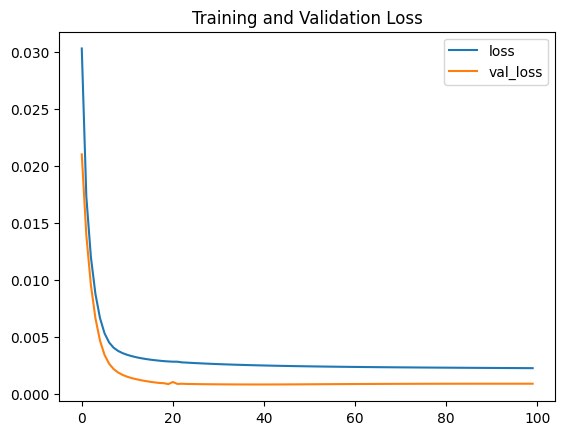

In [58]:
import matplotlib.pyplot as plt

loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

#  LSTM

In [73]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# parameters = [(1 (feature) * 16 (cells) ) + (16 * 16) hidden state weight matrix + 16 bias terms ] * 4 gates
(1*16 + 16*16 + 16) *4

1152

In [74]:
callbacks = [
    keras.callbacks.ModelCheckpoint("LSTM.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=300,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0111 - mae: 0.0891 - val_loss: 0.0101 - val_mae: 0.0825
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0109 - mae: 0.0877 - val_loss: 0.0100 - val_mae: 0.0823
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0108 - mae: 0.0870 - val_loss: 0.0100 - val_mae: 0.0816
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0107 - mae: 0.0866 - val_loss: 0.0099 - val_mae: 0.0821
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0106 - mae: 0.0864 - val_loss: 0.0099 - val_mae: 0.0817
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0105 - mae: 0.0860 - val_loss: 0.0097 - val_mae: 0.0813
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0104 - mae: 0.0855 - val_loss: 0.0097 - val_mae: 0.0810
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0102 - mae: 0.0850 - val_loss: 0.0096 - val_mae: 0.0809
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0101 - mae: 

In [75]:
model = keras.models.load_model("LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0015 - mae: 0.0265
Test MAE: 0.026


In [78]:
loss_df = pd.DataFrame(history.history)
loss_df.tail()


,loss,mae,val_loss,val_mae
295,0.002236,0.035196,0.001608,0.032039
296,0.002235,0.035182,0.001610,0.032054
297,0.002234,0.035168,0.001611,0.032069
298,0.002232,0.035154,0.001613,0.032092
299,0.002231,0.035140,0.001614,0.032115


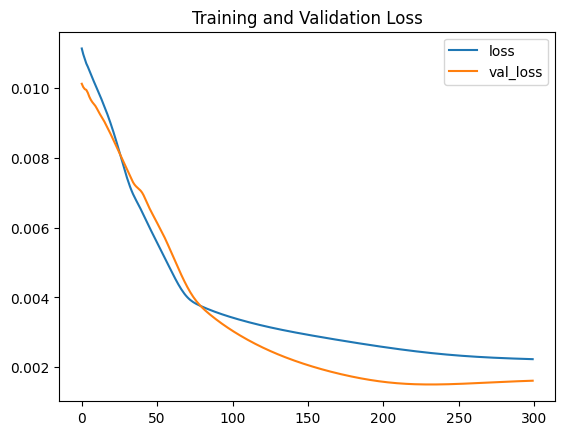

In [79]:
import matplotlib.pyplot as plt

loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

# More complex models with regularization

In [83]:
# We can stack multiple LSTM layers and add regularization.

inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.SimpleRNN(32, recurrent_dropout=0.1, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, recurrent_dropout=0.1)(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("RNN_stacked_regularized.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/100


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0934 - mae: 0.2426 - val_loss: 0.0191 - val_mae: 0.1167
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0721 - mae: 0.2174 - val_loss: 0.0078 - val_mae: 0.0740
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0572 - mae: 0.1861 - val_loss: 0.0061 - val_mae: 0.0650
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0389 - mae: 0.1570 - val_loss: 0.0029 - val_mae: 0.0464
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0267 - mae: 0.1337 - val_loss: 0.0076 - val_mae: 0.0807
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0302 - mae: 0.1392 - val_loss: 0.0019 - val_mae: 0.0382
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0388 - mae: 0.1534 - val_loss: 0.0041 - val_mae: 0.0510
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0285 - mae: 0.1415 - val_loss: 0.0051 - val_mae: 0.0582
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0284 - mae: 0.1339 - val

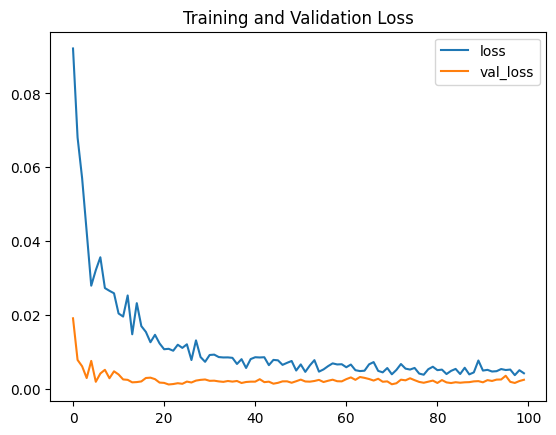

In [84]:
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

In [85]:
model = keras.models.load_model("RNN_stacked_regularized.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0012 - mae: 0.0312
Test MAE: 0.031


# Bidirectional RNN?

In [86]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.Bidirectional(layers.SimpleRNN(32))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("bidirectional_RNN.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0299 - mae: 0.1460 - val_loss: 0.0071 - val_mae: 0.0685
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0075 - mae: 0.0699 - val_loss: 0.0029 - val_mae: 0.0416
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042 - mae: 0.0506 - val_loss: 0.0017 - val_mae: 0.0344
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033 - mae: 0.0458 - val_loss: 0.0013 - val_mae: 0.0308
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030 - mae: 0.0438 - val_loss: 0.0012 - val_mae: 0.0295
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0424 - val_loss: 0.0012 - val_mae: 0.0303
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0418 - val_loss: 0.0013 - val_mae: 0.0314
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0415 - val_loss: 0.0014 - val_mae: 0.0323
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0

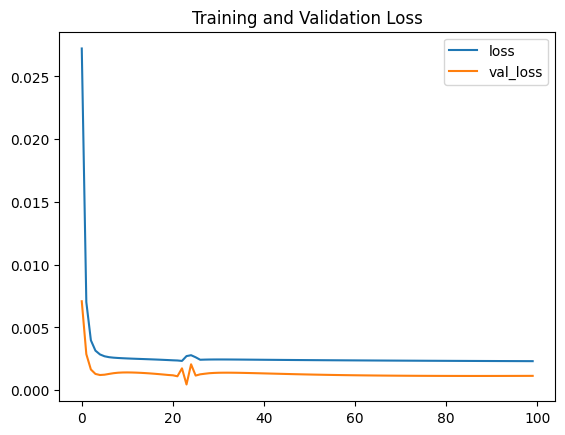

In [87]:
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot(legend=True, title='Training and Validation Loss')
plt.show()

In [88]:
model = keras.models.load_model("bidirectional_RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 5.7479e-04 - mae: 0.0173
Test MAE: 0.017


## Comparing Econometrics vs Machine Learning vs Deep Learning for univariate timeseries forecasting.
note: the numbers might change for the deep learning model due to randomization and number of epochs. 

**Benchmarks**
* Seasonal Naive Forecaster test MAE = 0.023
* Naive Forecaster test MAE = 0.11

**Econometrics**
* Auto ARIMA test MAE = 0.023
* Auto ETS test MAE = 0.030

**Machine Learning**
* Catboost test MAE = 0.025
* LightGBM test MAE = 0.028
* XGboost test MAE = 0.03
* Random Forest test MAE = 0.03

**Deep Learning**
* simple RNN test MAE = 0.022
* Simple LSTM test MAE = 0.026
* Stacked RNN with regularization = 0.031
* Bidirectional RNN test MAE = 0.019

# Done!